# Encoding word positions

mbedding layer convert IDs into identical vector representations regardless of where they are located in the input sequence:

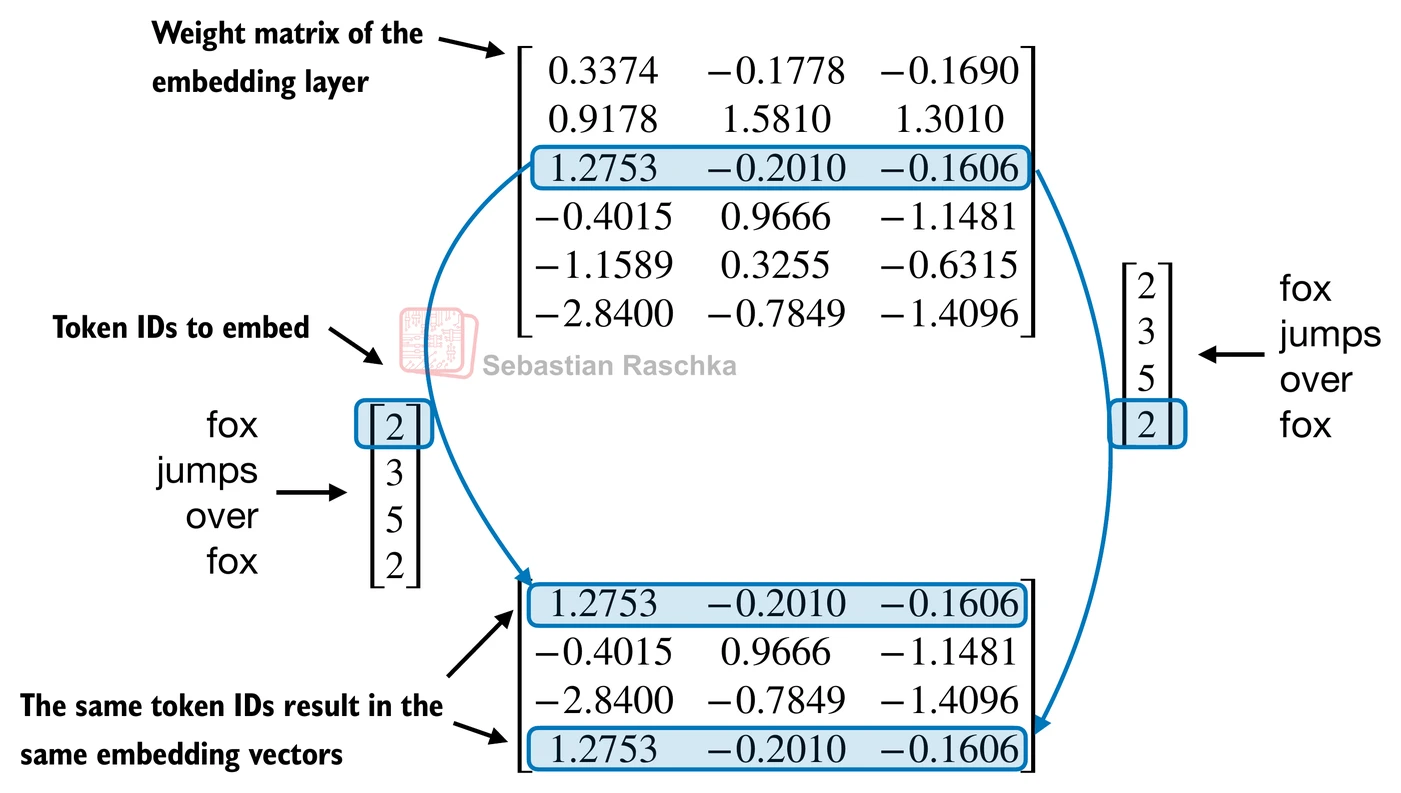

Positional embeddings are combined with the token embedding vector to form the input embeddings for a large language model:

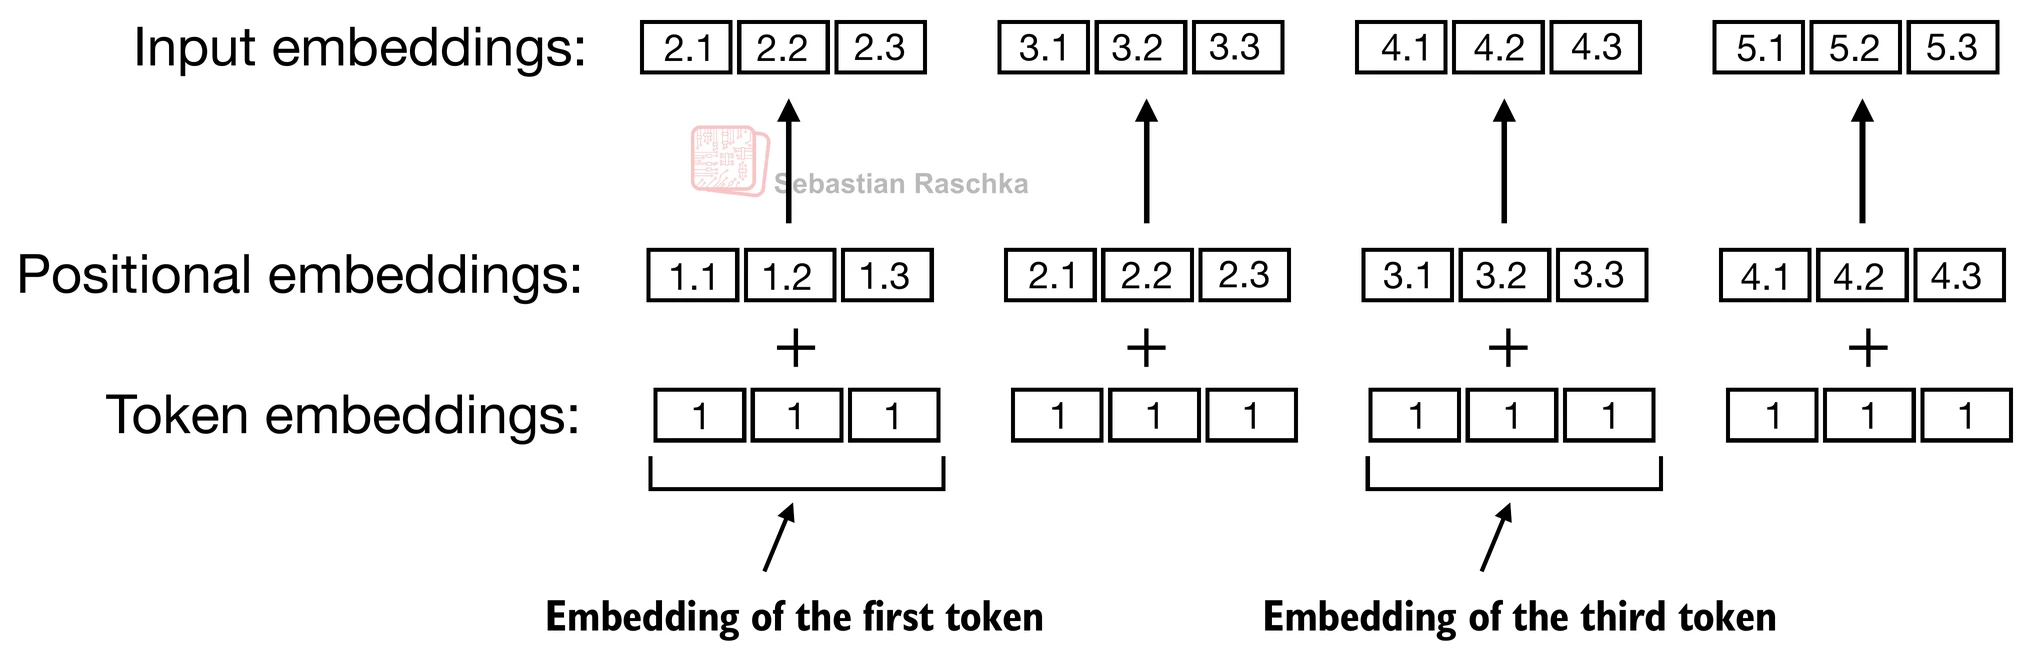

The BytePair encoder has a vocabulary size of 50,257:

Suppose we want to encode the input tokens into a 256-dimensional vector representation:

# Old code From previous noteobok

In [22]:
import torch
import tiktoken

In [23]:
from torch.utils.data import Dataset, DataLoader


class GPTDatasetV1(Dataset):
    def __init__(self, txt, tokenizer, max_length, stride):
        self.input_ids = []
        self.target_ids = []

        # Tokenize the entire text
        token_ids = tokenizer.encode(txt, allowed_special={"<|endoftext|>"})
        assert len(token_ids) > max_length, "Number of tokenized inputs must at least be equal to max_length+1"

        # Use a sliding window to chunk the book into overlapping sequences of max_length
        for i in range(0, len(token_ids) - max_length, stride):
            input_chunk = token_ids[i:i + max_length]
            target_chunk = token_ids[i + 1: i + max_length + 1]
            self.input_ids.append(torch.tensor(input_chunk))
            self.target_ids.append(torch.tensor(target_chunk))

    def __len__(self):
        return len(self.input_ids)

    def __getitem__(self, idx):
        return self.input_ids[idx], self.target_ids[idx]

In [24]:
def create_dataloader_v1(txt, batch_size=4, max_length=256, 
                         stride=128, shuffle=True, drop_last=True,
                         num_workers=0):

    # Initialize the tokenizer
    tokenizer = tiktoken.get_encoding("gpt2")

    # Create dataset
    dataset = GPTDatasetV1(txt, tokenizer, max_length, stride)

    # Create dataloader
    dataloader = DataLoader(
        dataset,
        batch_size=batch_size,
        shuffle=shuffle,
        drop_last=drop_last,
        num_workers=num_workers
    )

    return dataloader

In [25]:
with open("the verdict.txt", "r", encoding="utf-8") as f:
    raw_text = f.read()
    
print("Total number of character:", len(raw_text))
print(raw_text[:99])

Total number of character: 20479
I HAD always thought Jack Gisburn rather a cheap genius--though a good fellow enough--so it was no 


# ------------------------------------------------------

In [26]:
import torch

In [27]:
vocab_size = 50257
output_dim = 256

token_embedding_layer = torch.nn.Embedding(vocab_size, output_dim)

Using the token_embedding_layer above, if we sample data from the data loader, we embed each token in each batch into a 256-dimensional vector. If we have a batch size of 8 with four tokens each, the result will be an 8 x 4 x 256 tensor.



Let's instantiate the data loader ( Data sampling with a sliding window), first:

In [30]:
max_length = 4
dataloader = create_dataloader_v1(
    raw_text, batch_size = 8, max_length = max_length,
    stride = max_length, shuffle = False
)

data_iter = iter(dataloader)
inputs, targets = next(data_iter)


In [31]:
print("Token IDs: \n", inputs)
print("\n Input Shape: \n", inputs.shape)

Token IDs: 
 tensor([[   40,   367,  2885,  1464],
        [ 1807,  3619,   402,   271],
        [10899,  2138,   257,  7026],
        [15632,   438,  2016,   257],
        [  922,  5891,  1576,   438],
        [  568,   340,   373,   645],
        [ 1049,  5975,   284,   502],
        [  284,  3285,   326,    11]])

 Input Shape: 
 torch.Size([8, 4])


As we can see, the token ID tensor is 8x4-dimensional, meaning that the data batch consists of 8 text samples with 4 tokens each.

Let's now use the embedding layer to embed these token IDs into 256-dimensional vectors:

In [32]:
token_embeddings = token_embedding_layer(inputs)
print(token_embeddings.shape)

torch.Size([8, 4, 256])


As we can tell based on the 8x4x256-dimensional tensor output, each token ID is now embedded as a 256-dimensional vector.

For a GPT model's absolute embedding approach, we just need to create another embedding layer that has the same dimension as the token_embedding_layer:

In [33]:
context_length = max_length
pos_embedding_layer = torch.nn.Embedding(context_length, output_dim)

In [35]:
post_embedding = pos_embedding_layer(torch.arange(max_length))
print(post_embedding.shape)

torch.Size([4, 256])


As shown in the preceding code example, the input to the pos_embeddings is usually a placeholder vector torch.arange(context_length), which contains a sequence of numbers 0, 1, ..., up to the maximum input length − 1.

The context_length is a variable that represents the supported input size of the LLM.

Here, we choose it similar to the maximum length of the input text.

In practice, input text can be longer than the supported context length, in which case we have to truncate the text.

As we can see, the positional embedding tensor consists of four 256-dimensional vectors. We can now add these directly to the token embeddings, where PyTorch will add the 4x256- dimensional pos_embeddings tensor to each 4x256-dimensional token embedding tensor in each of the 8 batches:

In [36]:
input_embedding = token_embeddings + post_embedding
print(input_embedding.shape)

torch.Size([8, 4, 256])


The input_embeddings we created are the embedded input examples that can now be processed by the main LLM modules

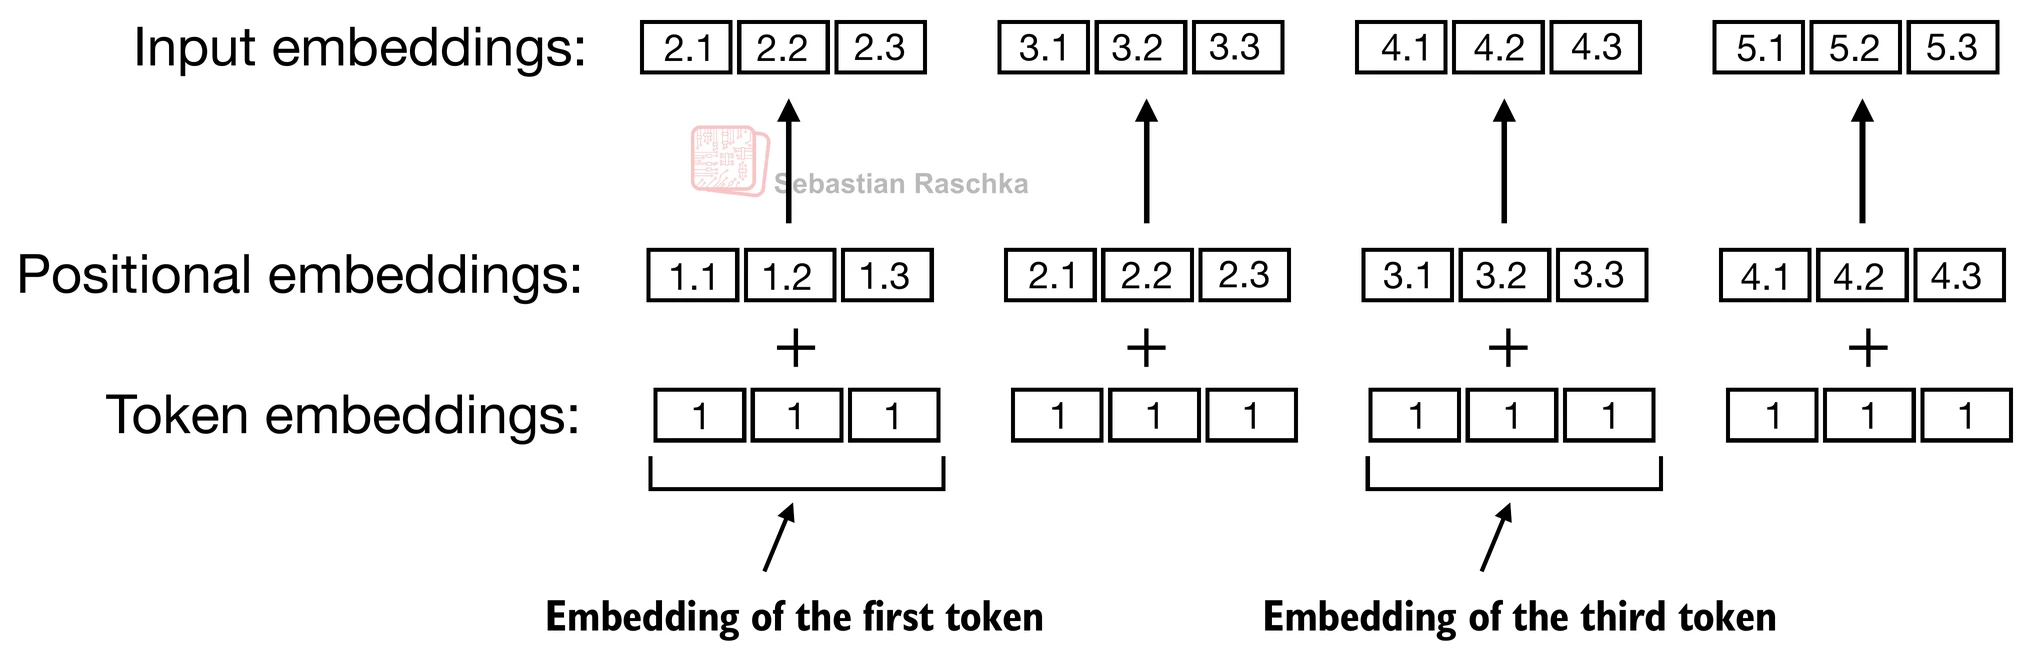

In [38]:
print(token_embeddings)

tensor([[[ 0.4383,  0.2429, -0.0116,  ..., -0.2179,  0.2841, -3.0598],
         [-0.1621,  0.6856, -0.8555,  ...,  0.0561,  0.8210,  0.0733],
         [-0.3496,  0.4307,  0.5212,  ...,  0.5422,  1.2914,  0.2523],
         [-0.8167,  0.0227,  0.7933,  ...,  1.5251, -0.0177,  0.4218]],

        [[ 0.5339, -0.2987,  0.1722,  ...,  0.4295,  1.1392, -0.4924],
         [ 0.2428, -0.1829,  0.8719,  ...,  0.3243, -0.4112, -1.0026],
         [ 0.0445, -0.6312,  1.0176,  ..., -3.2137,  1.1844, -0.3883],
         [-0.4086,  1.7158, -1.2718,  ..., -0.1620,  0.5956,  1.2343]],

        [[ 0.4318,  1.0110,  1.0560,  ..., -0.1983, -0.1198, -0.4060],
         [ 0.3660,  0.6575, -0.0988,  ..., -0.5498,  1.4799, -0.7193],
         [-1.1750, -0.8497,  1.3442,  ...,  2.0068,  1.4899, -0.9666],
         [-0.8290,  0.0816, -0.3615,  ..., -1.3628,  0.1354, -0.0145]],

        ...,

        [[-0.6309, -0.8286,  0.7463,  ..., -0.5796, -2.5383, -0.6381],
         [ 0.4633, -0.5229,  0.1321,  ...,  0.6945,  1.39

In [39]:
print(post_embedding)

tensor([[ 0.3260,  1.4780, -0.5380,  ...,  1.6013, -0.0597,  0.7564],
        [-0.0502, -1.6724,  0.4951,  ..., -2.9413,  1.6884, -0.2334],
        [ 1.3825, -1.3234, -1.1093,  ...,  0.5008,  1.1302, -0.6461],
        [-1.1600, -0.9236,  0.5948,  ..., -1.6839, -0.8269, -0.3419]],
       grad_fn=<EmbeddingBackward0>)


In [40]:
print(input_embedding)

tensor([[[ 0.7643,  1.7209, -0.5496,  ...,  1.3834,  0.2244, -2.3034],
         [-0.2123, -0.9869, -0.3603,  ..., -2.8852,  2.5094, -0.1601],
         [ 1.0330, -0.8927, -0.5881,  ...,  1.0430,  2.4216, -0.3938],
         [-1.9766, -0.9009,  1.3882,  ..., -0.1588, -0.8446,  0.0798]],

        [[ 0.8599,  1.1793, -0.3658,  ...,  2.0308,  1.0795,  0.2640],
         [ 0.1926, -1.8553,  1.3671,  ..., -2.6171,  1.2772, -1.2360],
         [ 1.4270, -1.9546, -0.0917,  ..., -2.7129,  2.3146, -1.0345],
         [-1.5686,  0.7921, -0.6770,  ..., -1.8459, -0.2313,  0.8924]],

        [[ 0.7578,  2.4890,  0.5180,  ...,  1.4030, -0.1795,  0.3504],
         [ 0.3159, -1.0150,  0.3963,  ..., -3.4911,  3.1683, -0.9527],
         [ 0.2075, -2.1731,  0.2349,  ...,  2.5077,  2.6201, -1.6128],
         [-1.9890, -0.8420,  0.2333,  ..., -3.0467, -0.6915, -0.3564]],

        ...,

        [[-0.3048,  0.6494,  0.2083,  ...,  1.0217, -2.5979,  0.1183],
         [ 0.4131, -2.1953,  0.6272,  ..., -2.2468,  3.08

In the initial phase of the input processing workflow, the input text is segmented into separate tokens

Following this segmentation, these tokens are transformed into token IDs based on a predefined vocabulary:

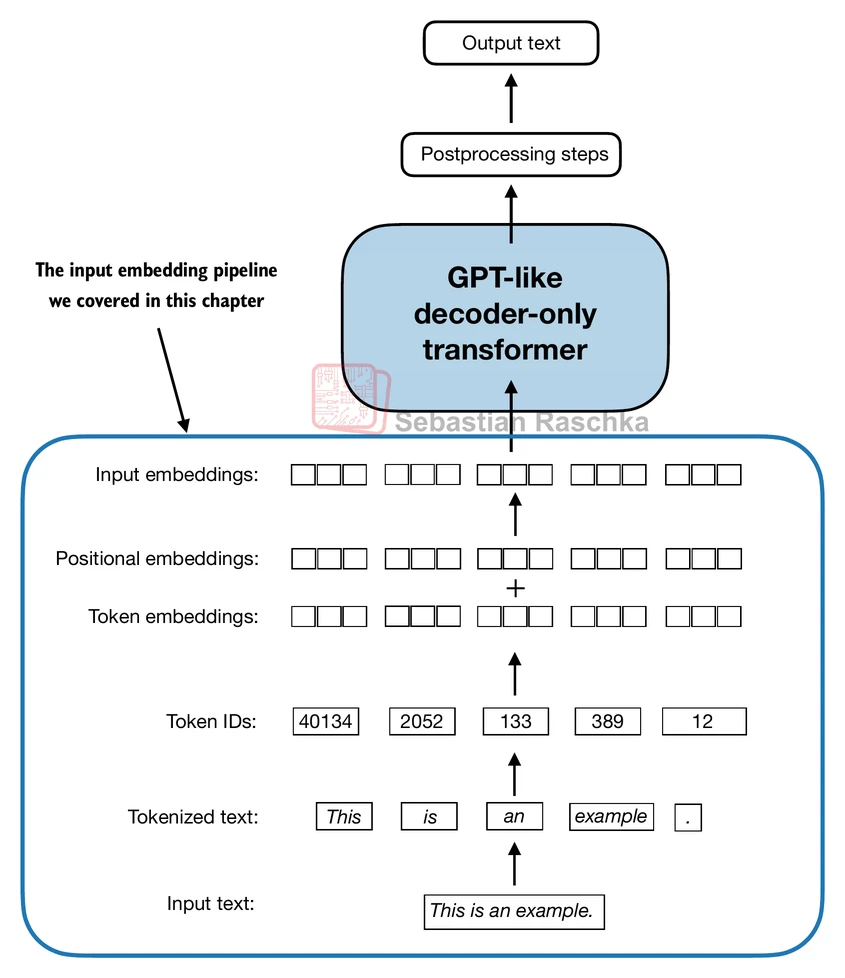